<a href="https://colab.research.google.com/github/trungtrinh44/ibnn/blob/bnn/toy_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
from ibnn.models import StoLayer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class MLP(nn.Module):
  def __init__(self, layer_sizes, std, n_components=4, prior_mean=1.0, prior_std=0.3, posterior_mean_init=(1.0, 0.5), posterior_std_init=(0.05, 0.02)):
    super(MLP, self).__init__()
    self.n_components = n_components
    layers = [
        StoLayer((1, ), n_components, prior_mean, prior_std, posterior_mean_init, posterior_std_init),
        nn.Linear(1, layer_sizes[0])
    ]
    for isz, osz in zip(layer_sizes[:-1], layer_sizes[1:]):
      layers.extend([
          nn.ReLU(inplace=True),
          StoLayer((isz, ), n_components, prior_mean, prior_std, posterior_mean_init, posterior_std_init),
          nn.Linear(isz, osz)
      ])
    self.layers = nn.ModuleList(layers)
    self.std = std
    self.sto_modules = [
      m for m in self.modules() if isinstance(m, StoLayer)
    ]

  def forward(self, x, L=1, indices=None):
    if L > 1:
      x = torch.repeat_interleave(x, L, 0)
    if indices is None:
      indices = torch.arange(x.size(0), device=x.device, dtype=torch.long) % self.n_components
    for layer in self.layers:
      if isinstance(layer, StoLayer):
        x = layer(x, indices)
      else:
        x = layer(x)
    x = x.view(-1, L)
    return x
  
  def kl(self):
    return sum(m.kl() for m in self.sto_modules)

  def vb_loss(self, x, y, n_sample):
    y = y.unsqueeze(1).expand(-1, n_sample)
    logp = D.Normal(self.forward(x, n_sample), self.std).log_prob(y).mean()
    return -logp, self.kl()
  
  def nll(self, x, y, n_sample):
    indices = torch.empty(x.size(0)*n_sample, dtype=torch.long, device=x.device)
    mean = torch.cat([self.forward(x, n_sample, indices=torch.full((x.size(0)*n_sample,), idx, out=indices, device=x.device, dtype=torch.long)) for idx in range(self.n_components)], dim=1)
    logp = D.Normal(mean, self.std).log_prob(y.unsqueeze(1).expand(-1, self.n_components*n_sample))
    logp = torch.logsumexp(logp, 1) - torch.log(torch.tensor(self.n_components*n_sample, dtype=torch.float32, device=x.device))
    return -logp.mean(), prob

In [3]:
def generate_data():
  train_x = torch.cat([torch.arange(-3, -1.0, 0.01), torch.arange(1, 3, 0.01)])
  train_y = train_x**3 + torch.randn_like(train_x)*2
  test_x = torch.cat([torch.arange(-5, -3, 0.1), torch.arange(-1, 1, 0.1), torch.arange(3, 5, 0.1)])
  test_y = test_x**3 + torch.randn_like(test_x)*2
  return train_x, train_y, test_x, test_y

In [4]:
train_x, train_y, test_x, test_y = generate_data()

In [5]:
n_layers = 5
model = MLP([256]*n_layers + [1], 1.0, 8)

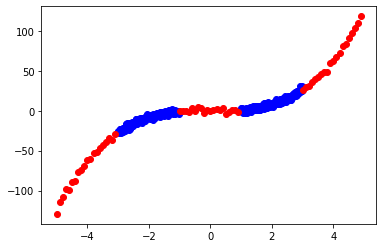

In [6]:
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'ro')
plt.show()

In [7]:
detpar = []
stopar = []
for name, param in model.named_parameters():
  if 'posterior_mean' in name or 'posterior_std' in name:
    stopar.append(param)
  else:
    detpar.append(param)
optimizer = torch.optim.Adam(
  [
    {'params': stopar, 'lr': 0.008}, {'params': detpar, 'lr': 0.001} 
  ]#, momentum=0.9, nesterov=True
)

In [8]:
model.to('cuda')
train_xi = train_x.unsqueeze(1).to('cuda')
train_yi = train_y.to('cuda')
kl_weight = 0
for _ in range(5000):
  loglike, kl = model.vb_loss(train_xi, train_yi, 8)
  loss = loglike + kl_weight*kl
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  kl_weight = min(1.0,  kl_weight + 1.0/1000.0)
  print(f"Loglike: {loglike.item():.4f}, kl: {kl.item():.4f}, kl weight: {kl_weight:.4f}", end='\r')

In [9]:
test_y = model.forward(torch.arange(-5, 5, 0.1, device='cuda').unsqueeze(1), 60)

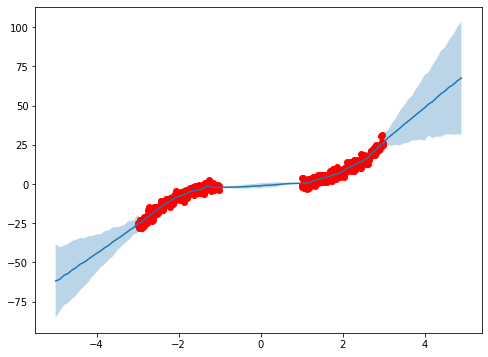

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(train_x, train_y, 'ro')
plt.plot(
    torch.arange(-5, 5, 0.1).numpy(), 
    test_y.mean(1).cpu().detach().numpy()
)
plt.fill_between(
    torch.arange(-5, 5, 0.1).numpy(),
    test_y.mean(1).cpu().detach().numpy() - 2*test_y.std(1).cpu().detach().numpy(),
    test_y.mean(1).cpu().detach().numpy() + 2*test_y.std(1).cpu().detach().numpy(), alpha=0.3
)
plt.savefig(f'ibnn_{n_layers}.pdf')